# Ejercicio 1: Regresión Lineal


---

Con los datos presentes en la carpeta Datos/Forecasting de la clase 2 construyan un modelo de regresión lineal que les permita realizar una predicción futura de la variable Sales quantity. Experimenten con distintas transformaciones de los datos, regresiones polinómicas u otras técnicas que las utilizadas en clase para obtener el mejor modelo posible en testing.


## 1. Importación de librerías

Se importan librerías para manipulación de datos (`numpy`, `pandas`), visualización (`matplotlib`), modelado estadístico y machine learning (`scipy`, `sklearn`), y otras utilidades.

In [ ]:
# Importamos librerias
import numpy as np
from itertools import combinations_with_replacement
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
import pandas as pd
from scipy.stats import boxcox
from scipy.special import inv_boxcox


## 2. Carga y exploración de datos
Se cargan los datos desde Google Drive usando el enlace de descarga directa y se visualizan las primeras filas para verificar la correcta importación.

In [ ]:
# Cargar datos
df = pd.read_csv('Month_Value_1.csv', parse_dates=['Period'], dayfirst=True)

# Exploración inicial del DataFrame
df.head()

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,2015-01-01,1.601007e+07,12729.0,1257.763541,30024676.0
1,2015-02-01,1.580759e+07,11636.0,1358.507000,30024676.0
2,2015-03-01,2.204715e+07,15922.0,1384.697024,30024676.0
3,2015-04-01,1.881458e+07,15227.0,1235.606705,30024676.0
4,2015-05-01,1.402148e+07,8620.0,1626.621765,30024676.0



Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 5 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Period                                    96 non-null     datetime64[ns]
 1   Revenue                                   64 non-null     float64       
 2   Sales_quantity                            64 non-null     float64       
 3   Average_cost                              64 non-null     float64       
 4   The_average_annual_payroll_of_the_region  64 non-null     float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 3.9 KB
None

Estadísticas descriptivas:
                    Period       Revenue  Sales_quantity  Average_cost  \
count                   96  6.400000e+01       64.000000     64.000000   
mean   2018-12-16 05:00:00  3.236045e+07    19197.375000   1695.061159   
mi

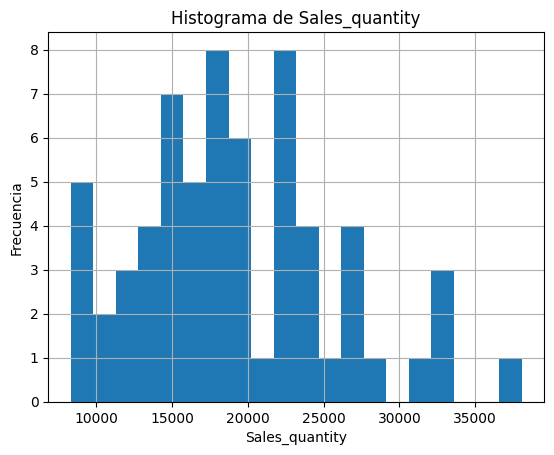

In [ ]:
print('\nInformación general del DataFrame:')
print(df.info())

print('\nEstadísticas descriptivas:')
print(df.describe())

print('\nCantidad de valores nulos por columna:')
print(df.isnull().sum())

print('\nDistribución de la variable objetivo (Sales_quantity):')
print(df['Sales_quantity'].describe())
df['Sales_quantity'].hist(bins=20)
plt.title('Histograma de Sales_quantity')
plt.xlabel('Sales_quantity')
plt.ylabel('Frecuencia')
plt.show()

### 2.1. Procesamiento de datos
Se eliminan filas con valores faltantes y se asegura el orden cronológico de la columna `Period`.

In [ ]:
# Eliminar filas con valores faltantes (como las de 2020-2021)
df = df.dropna(subset=['Revenue', 'Sales_quantity', 'Average_cost'])

# Verificar resultado
print(df.head())
print(f"\nDatos disponibles desde {df['Period'].min()} hasta {df['Period'].max()}")

      Period       Revenue  Sales_quantity  Average_cost  \
0 2015-01-01  1.601007e+07         12729.0   1257.763541   
1 2015-02-01  1.580759e+07         11636.0   1358.507000   
2 2015-03-01  2.204715e+07         15922.0   1384.697024   
3 2015-04-01  1.881458e+07         15227.0   1235.606705   
4 2015-05-01  1.402148e+07          8620.0   1626.621765   

   The_average_annual_payroll_of_the_region  
0                                30024676.0  
1                                30024676.0  
2                                30024676.0  
3                                30024676.0  
4                                30024676.0  

Datos disponibles desde 2015-01-01 00:00:00 hasta 2020-04-01 00:00:00


In [ ]:
# Convierte la columna 'Period' a formato de fecha y ordena el DataFrame cronológicamente
df['Period'] = pd.to_datetime(df['Period'], format='%d.%m.%Y')
df = df.sort_values(by='Period').reset_index(drop=True)


In [ ]:
df

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,2015-01-01,1.601007e+07,12729.0,1257.763541,30024676.0
1,2015-02-01,1.580759e+07,11636.0,1358.507000,30024676.0
2,2015-03-01,2.204715e+07,15922.0,1384.697024,30024676.0
3,2015-04-01,1.881458e+07,15227.0,1235.606705,30024676.0
4,2015-05-01,1.402148e+07,8620.0,1626.621765,30024676.0
...,...,...,...,...,...
59,2019-12-01,5.875647e+07,38069.0,1543.420464,29878525.0
60,2020-01-01,5.628830e+07,27184.0,2070.640850,29044998.0
61,2020-02-01,4.022524e+07,23509.0,1711.057181,29044998.0
62,2020-03-01,5.002217e+07,32569.0,1535.882748,29044998.0


## 3. Definición de la clase de Regresión Polinómica

Se implementa una clase para ajustar modelos de regresión polinómica de cualquier grado, usando el método analítico. Esta clase permite crear variables polinómicas, entrenar, predecir y calcular métricas de error.


In [ ]:
# Algoritmo de regresión polinómica
class RegPolinomica():
    def __init__(self):
        self.params = None
        self.trained = False
        self.degree = 1
        self.cost_history = []


    def _create_poly_features(self, X, degree):
        X = np.asarray(X)  # Convierte la entrada a array de NumPy
        if X.ndim == 1:   # Si es 1D (vector), lo convierte a 2D (matriz)
            X = X.reshape(-1, 1)

        n_samples, n_features = X.shape  # Obtiene dimensiones
        features = [np.ones(n_samples)]  # Inicia con columna de 1s (término bias)

        # Genera todas las combinaciones de características hasta el grado deseado
        for d in range(1, degree + 1):  # Para cada grado (1 a 'degree')
            for comb in combinations_with_replacement(range(n_features), d):
                feature = np.prod([X[:, i] for i in comb], axis=0)
                features.append(feature)

        return np.column_stack(features)  # Combina todas las columnas

    def fit(self, X_train, y_train, degree=1, verb=False):

        self.degree = degree
        X_poly = self._create_poly_features(X_train, degree)
        n_samples = X_poly.shape[0]

        # Inicialización de parámetros
        self.params = np.zeros(X_poly.shape[1])
        self.cost_history = []
        self.params = np.linalg.pinv(X_poly.T @ X_poly) @ X_poly.T @ y_train
        if verb==True:
          print ('¡Modelo entrenado analíticamente!')
        self.trained = True

    def get_params(self):
        if not self.trained:
            raise Exception('El modelo no está entrenado.')
        return self.params

    def get_costo(self, X_train, y_train):
        # Devuelve el costo total del modelo sobre los datos de entrenamiento
        if not self.trained:
            raise Exception('El modelo no está entrenado.')
        X_poly = self._create_poly_features(X_train, self.degree)
        error = X_poly @ self.params.T - y_train
        return 0.5 * (error.T @ error)

    def score(self, X_test, y_test, degree):
        # Devuelve el error cuadrático medio sobre el conjunto de prueba
        if not self.trained:
            raise Exception('El modelo no está entrenado.')
        X_poly = self._create_poly_features(X_test, degree)
        n = X_poly.shape[0]
        error = X_poly @ self.params.T - y_test
        return (1 / n) * (error.T @ error)


    def predict(self, X_test, degree=None):
        # Realiza predicciones sobre un nuevo conjunto de datos
        if not self.trained:
            raise Exception('El modelo no está entrenado.')
        if degree is None:
            degree = self.degree
        X_poly = self._create_poly_features(X_test, degree)
        return X_poly @ self.params.T


## 4. Funciones de transformación/desestacionalización
Se definen funciones para transformar la serie temporal: Media Móvil, Box-Cox, Log Media Móvil, Diferencia Simple.
Se generan variables de rezago (lags) para usar como predictores. Estas transformaciones ayudan a estabilizar la varianza y/o eliminar tendencias y estacionalidad.

In [ ]:
# Funciones para desestacionalizar
def prepare_data(df, transf_type, window_size):
    df_transf = df.copy()

    if transf_type == 'Media Móvil':
        df_transf['Media_Movil'] = df_transf['Sales_quantity'].shift(1).rolling(window=window_size).mean()
        df_transf['Desestacionalizacion'] = df_transf['Sales_quantity'] - df_transf['Media_Movil']
        col_name = 'Desestacionalizacion'
    elif transf_type == 'Box-Cox':
        df_transf['Sales_quantity_boxcox'], lambda_val = boxcox(df_transf['Sales_quantity'])
        transform_params['Box-Cox'] = {'lambda': lambda_val}
        col_name = 'Sales_quantity_boxcox'
    elif transf_type == 'Log Media Móvil':
        df_transf['Log_Sales'] = np.log1p(df_transf['Sales_quantity'])
        df_transf['Media_Movil_Log'] = df_transf['Log_Sales'].shift(1).rolling(window=window_size).mean()
        df_transf['Desestacionalizacion_Log'] = df_transf['Log_Sales'] - df_transf['Media_Movil_Log']
        col_name = 'Desestacionalizacion_Log'
    elif transf_type == 'Diff Simple':
        df_transf['Desestacionalizacion_diff_simple'] = df_transf['Sales_quantity'].diff()
        df_transf['Media_Movil_diff'] = df['Sales_quantity'].shift(1).rolling(window=1, center=False).mean()
        col_name = 'Desestacionalizacion_diff_simple'
    else:
        raise ValueError('Transformación no reconocida')

    for i in range(1, window_size + 1):
        df_transf[f'Lag_{i}'] = df_transf[col_name].shift(i)
    df_transf.dropna(inplace=True)

    X = df_transf[[f'Lag_{i}' for i in range(1, window_size + 1)]]
    y = df_transf[col_name]

    return X, y, df_transf


## 5. Visualización de transformaciones
Se grafican las series transformadas para así comparar visualmente cada una y así elegir la transformación más adecuada para el modelado.

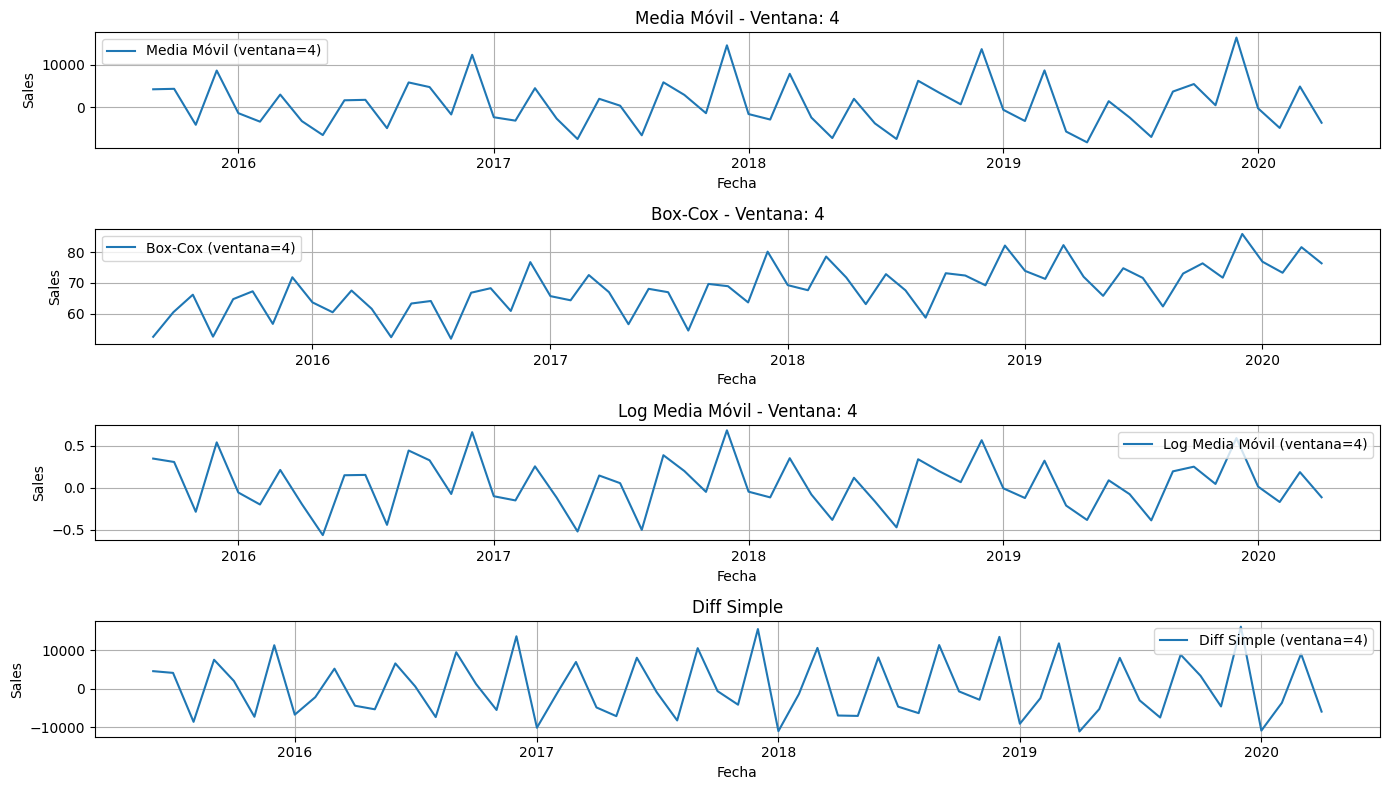

In [ ]:
# Probamos algunas
transform_params = {}
configuraciones = [
    {'transf_type': 'Media Móvil', 'window_size': 4},
    {'transf_type': 'Box-Cox', 'window_size': 4},
    {'transf_type': 'Log Media Móvil', 'window_size': 4},
    {'transf_type': 'Diff Simple', 'window_size': 4},

]

# Configurar gráfico general
plt.figure(figsize=(14, 8))

# Bucle para graficar todas las configuraciones
for idx, config in enumerate(configuraciones, 1):
    transf_type = config['transf_type']
    window_size = config['window_size']

    # Preparar datos
    X, y, df_transf= prepare_data(df, transf_type, window_size)

    # Graficar
    plt.subplot(len(configuraciones), 1, idx)
    plt.plot(df_transf['Period'], df_transf[y.name], label=f'{transf_type} (ventana={window_size})')

    if transf_type !='Diff Simple':
      texto=f'{transf_type} - Ventana: {window_size}'
    else:
      texto=f'{transf_type}'
    plt.title(texto)
    plt.xlabel('Fecha')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)

# Ajustar diseño
plt.tight_layout()
plt.show()


## 6. Función para invertir transformaciones

Se implementa una función para llevar las predicciones a la escala original y poder compararlas con los valores reales.


In [ ]:
# Para invertir las transformaciones para poder compararlas
def invert_transformation(df_orig, df_transf, pred,indice, transf_type, window_size):
    """
        df_orig (pd.DataFrame): DataFrame original sin transformar.
        df_transf (pd.DataFrame): DataFrame transformado
        indice el indice para revertir las transformaciones
        pred (np.array or pd.Series): Predicciones en escala transformada.
        transf_type (str): Tipo de transformación usada ('Media Móvil', 'Box-Cox', etc.)
        window_size (int): Tamaño de ventana usado para crear lags.
        np.array: Valores predichos en la escala original.
    """
    if isinstance(pred, pd.Series):
        pred = pred.values  # Convertir a numpy array si es necesario

    if transf_type == 'Media Móvil':
        media_movil_test = df_transf.loc[indice, 'Media_Movil'].values
        pred_orig = pred+media_movil_test

    elif transf_type == 'Box-Cox':
        pred_orig = inv_boxcox(pred, transform_params['Box-Cox']['lambda'])

    elif transf_type == 'Log Media Móvil':
        media_movil_test = df_transf.loc[indice, 'Media_Movil_Log'].values
        pred_log_sales = pred + media_movil_test
        pred_orig = np.expm1(pred_log_sales)

    elif transf_type == 'Diff Simple':
         media_movil_test = df_transf.loc[indice, 'Media_Movil_diff']
         pred_orig = pred + media_movil_test



    else:
        raise ValueError(f"Transformación '{transf_type}' no reconocida.")

    return pred_orig


## 7. Entrenamiento y evaluación de los modelos
Por cada transformación y grado polinómico (1, 2, 3), se entrena un modelo, para predecir y calcular el error (MSE). Cada resultado se almacena para graficar y por comparar. Por último, se utiliza un conjunto de entrenamiento (train) y otro de prueba (test) para evaluar la capacidad predictiva.

In [ ]:
#Graficamos algunas
n = 4  # Tamaño de ventana

# Transformaciones disponibles
transformaciones = [
    {'nombre': 'Media Móvil', 'columna': 'Desestacionalizacion'},
    {'nombre': 'Box-Cox', 'columna': 'Sales_quantity_boxcox'},
    {'nombre': 'Log Media Móvil', 'columna': 'Desestacionalizacion_Log'},
    {'nombre': 'Diff Simple', 'columna': 'Desestacionalizacion_diff_simple'}
]

# Diccionario para almacenar resultados
resultados = {t['nombre']: {'grado1': None, 'grado2': None, 'grado3': None} for t in transformaciones}

# Bucle principal: pruebo cada transformación y grado
for transf in transformaciones:
    df_transf = df.copy()

    X, y, df_transf = prepare_data(df, transf_type=transf['nombre'], window_size=n)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Entrenar modelo para diferentes grados
    for grado in [1, 2, 3]:
        modelo = RegPolinomica()
        modelo.fit(X_train, y_train, degree=grado)
        pred_transf = modelo.predict(X_test, grado)

        pred_orig = invert_transformation(df, df_transf, pred_transf, X_test.index, transf_type=transf['nombre'], window_size=n)
        real_orig = df_transf.loc[X_test.index, 'Sales_quantity']

        mse = np.mean((real_orig - pred_orig) ** 2)

        # Almacenar resultados
        test_dates = df_transf.loc[X_test.index, 'Period']
        resultados[transf['nombre']][f'grado{grado}'] = {
            'dates': test_dates,
            'real': real_orig,
            'pred': pred_orig,
            'mse': mse
        }


## 8. Visualización de los resultados
Se grafican los valores reales vs. predichos para cada transformación y grado, mostrando el error obtenido.



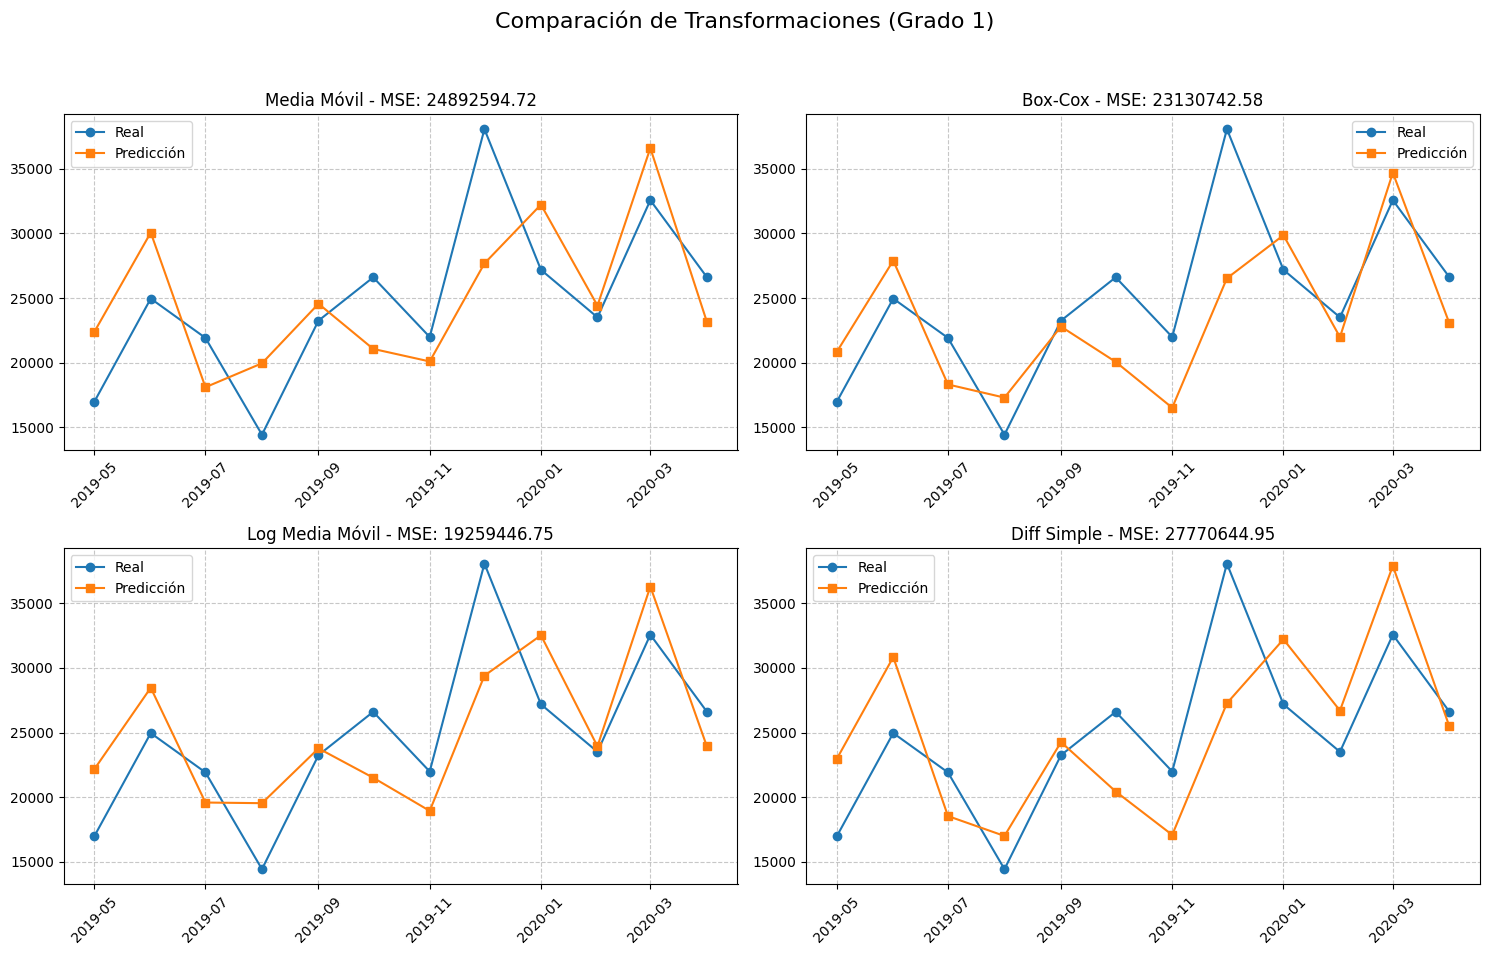

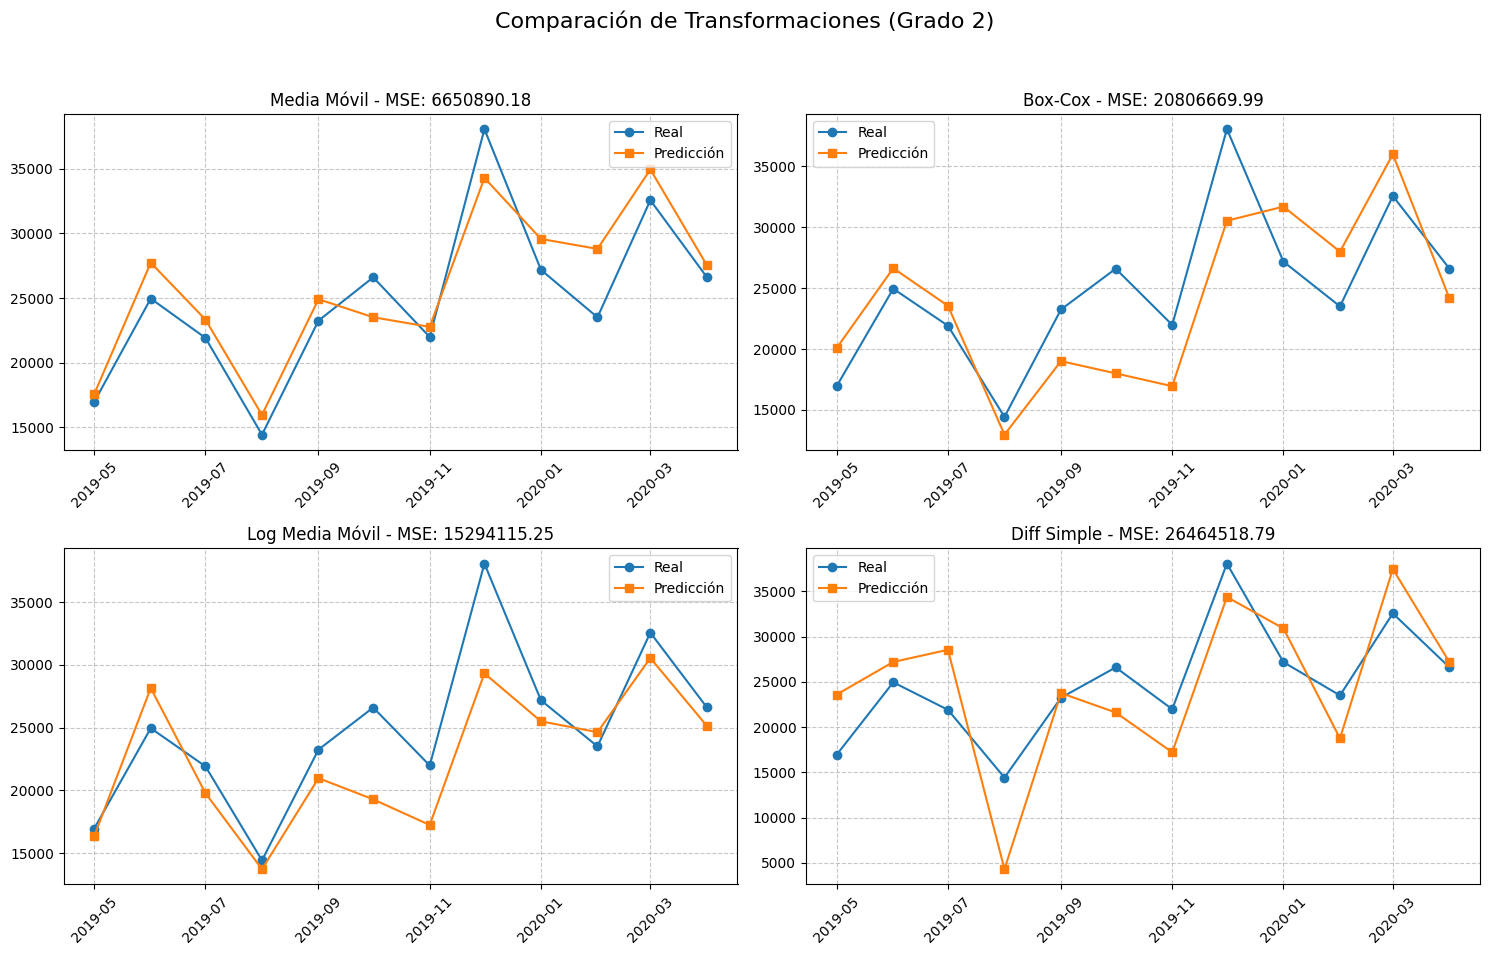

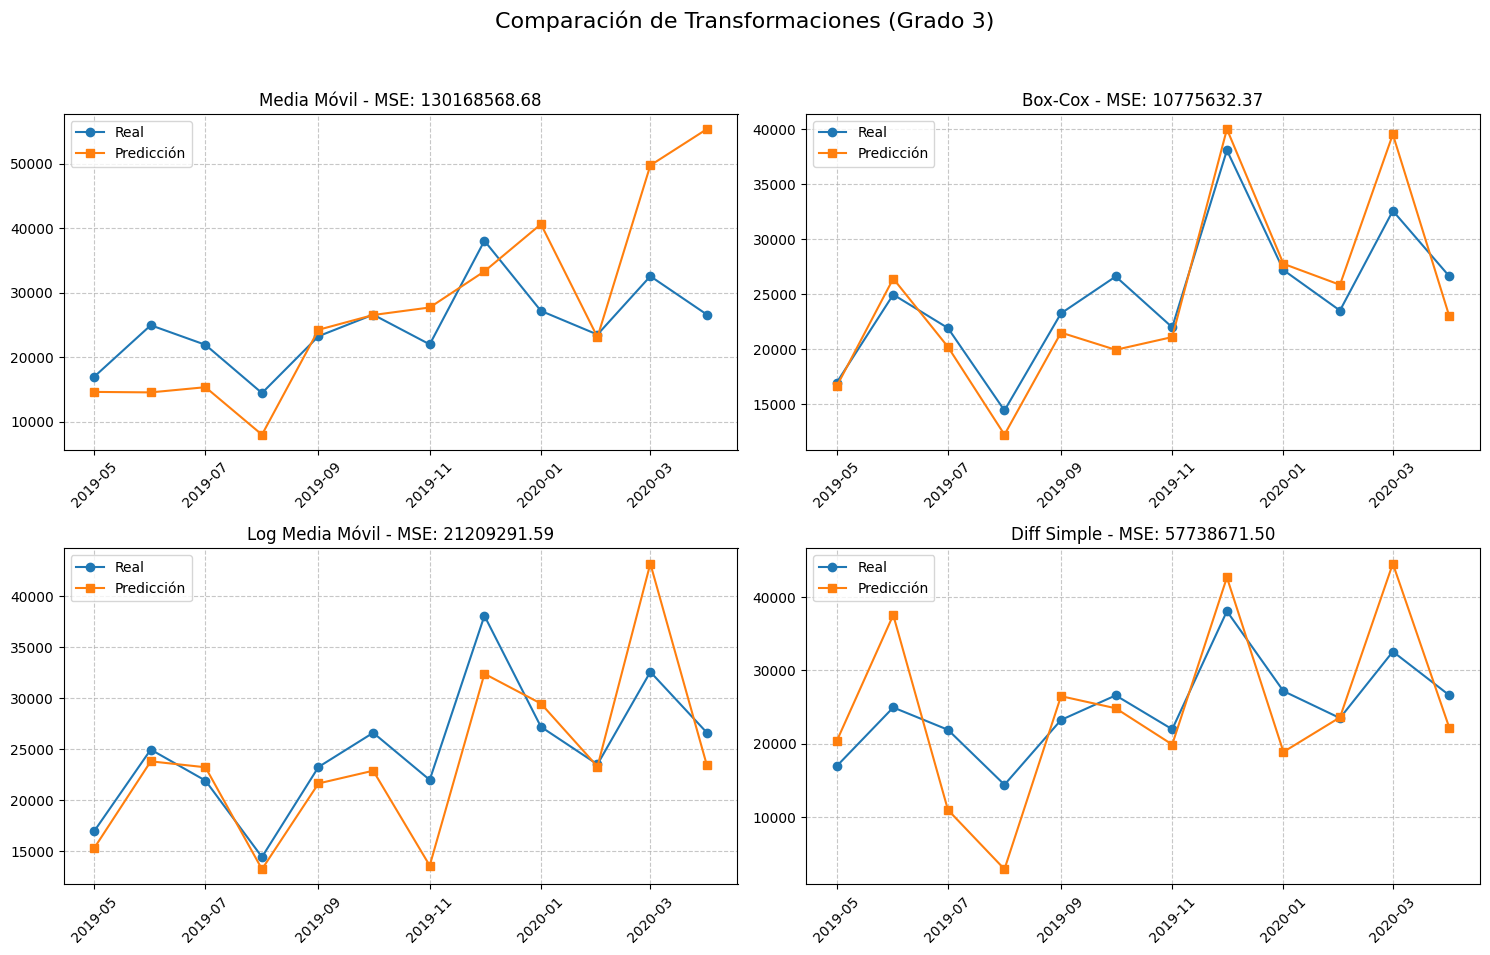

In [ ]:

# Función para graficar resultados por grado
def plot_results(degree):
    plt.figure(figsize=(15, 10))
    plt.suptitle(f'Comparación de Transformaciones (Grado {degree})', fontsize=16)

    for idx, transf in enumerate(transformaciones, 1):
        data = resultados[transf['nombre']][f'grado{degree}']
        df_plot = pd.DataFrame({
            'Period': data['dates'],
            'Real': data['real'],
            'Predicción': data['pred']
        }).sort_values('Period')

        plt.subplot(2, 2, idx)
        plt.plot(df_plot['Period'], df_plot['Real'], '-o', label='Real')
        plt.plot(df_plot['Period'], df_plot['Predicción'], '-s', label='Predicción')
        plt.title(f"{transf['nombre']} - MSE: {data['mse']:.2f}")
        plt.xticks(rotation=45)
        plt.grid(linestyle='--', alpha=0.7)
        plt.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Generar gráficos para todos los grados
plot_results(1)  # Grado 1
plot_results(2)  # Grado 2
plot_results(3)  # Grado 3


## 9. Búsqueda de la mejor combinación (Grid Search)
Se prueban las combinaciones de transformación, tamaño de ventana y grado polinómico, y se guarda el RMSE para cada una de las combinaciones, y así identificar la combinación óptima para el modelo.

In [ ]:
# Probamos varias y elegimos la de menor error
ventanas = [1,2,3,4,5, 6,7,8]           # Tamaño de ventana
grados = [1, 2, 3,4,5]             # Grados del modelo polinómico
transformaciones = [
    {'nombre': 'Media Móvil', 'columna': 'Desestacionalizacion'},
    {'nombre': 'Box-Cox', 'columna': 'Sales_quantity_boxcox'},
    {'nombre': 'Log Media Móvil', 'columna': 'Desestacionalizacion_Log'},
    {'nombre': 'Diff Simple', 'columna': 'Desestacionalizacion_diff_simple'}
]

# Diccionario para almacenar todos los resultados
resultados_grid = []

# Bucle principal: prueba todas las combinaciones
for transf in transformaciones:
    for window_size in ventanas:
        try:
            X, y, df_transf = prepare_data(df, transf_type=transf['nombre'], window_size=window_size)
            if len(X) < 10:  # Salta si hay muy pocos datos después de crear lags
                print(f"Saltando {transf['nombre']} con ventana={window_size}: pocos datos")
                continue

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

            #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=96)

            for grado in grados:
                modelo = RegPolinomica()
                modelo.fit(X_train, y_train, degree=grado)
                pred_transf = modelo.predict(X_test, grado)

                # Revertir transformación para obtener valores originales
                real_orig = df_transf.loc[X_test.index, 'Sales_quantity']
                pred_orig = invert_transformation(df, df_transf, pred_transf,X_test.index, transf_type=transf['nombre'], window_size=window_size)

                # Calcular MSE en escala original
                mse = np.mean((real_orig - pred_orig) ** 2)

                # Guardar resultados
                resultados_grid.append({
                    'Transformación': transf['nombre'],
                    'Ventana': window_size,
                    'Grado': grado,
                    'MSE': mse,
                    'Predicción': pred_orig,
                    'Real': real_orig,
                    'Fechas': df_transf.loc[X_test.index, 'Period']
                })

        except Exception as e:
            print(f"Error con {transf['nombre']} y ventana={window_size}: {e}")

df_resultados = pd.DataFrame(resultados_grid)
# Mostrar tabla pivotada
pivot_table = df_resultados.pivot_table(
    values='MSE',
    index=['Transformación', 'Ventana'],
    columns='Grado'
)
print("\nTabla RMSE por Transformación y Ventana:")
print(pivot_table)



Tabla RMSE por Transformación y Ventana:
Grado                               1             2             3  \
Transformación  Ventana                                             
Box-Cox         1        7.098785e+07  6.456654e+07  6.655395e+07   
                2        6.225081e+07  6.076101e+07  6.451327e+07   
                3        2.783121e+07  3.187514e+07  2.257998e+07   
                4        2.313074e+07  2.080667e+07  1.077563e+07   
                5        2.448708e+07  1.981504e+07  9.241370e+07   
                6        2.319176e+07  1.542786e+07  9.311443e+07   
                7        2.120615e+07  1.403242e+07  3.013221e+07   
                8        2.066630e+07  4.997439e+08  5.211441e+07   
Diff Simple     1        5.320045e+07  5.256286e+07  6.463604e+07   
                2        2.930174e+07  3.031796e+07  5.075183e+07   
                3        2.721664e+07  1.209476e+07  2.850022e+07   
                4        2.777064e+07  2.646452e+07  5.773867

## 10. Selección y visualización del mejor modelo
Selección del modelo con menor error y grafico sobre su desempeño.


In [ ]:
mejor = df_resultados.loc[df_resultados['MSE'].idxmin()]
print('Mejor modelo encontrado')
mejor.head()

Mejor modelo encontrado


,112
Transformación,Log Media Móvil
Ventana,7
Grado,3
MSE,1924419.694455
Predicción,"[21598.960840234824, 14734.158933877748, 26237..."


<Figure size 1200x600 with 0 Axes>

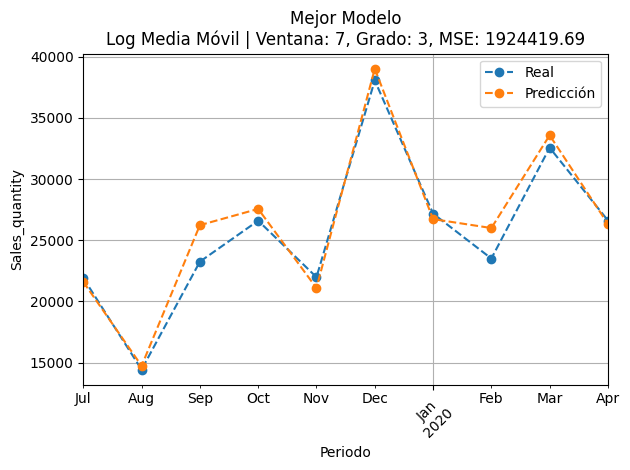

In [ ]:
plt.figure(figsize=(12, 6))
real = mejor['Real']
pred = mejor['Predicción']
fechas = mejor['Fechas']
df_plot = pd.DataFrame({
        'Period': fechas,
        'Real': real,
        'Predicción': pred
    }).sort_values('Period')
df_plot = df_plot.set_index('Period')

df_plot[['Real','Predicción']].plot(title=f"Mejor Modelo\n{mejor['Transformación']} | Ventana: {mejor['Ventana']}, Grado: {mejor['Grado']}, MSE: {mejor['MSE']:.2f}",
                 xlabel='Periodo', ylabel='Sales_quantity', marker='o', linestyle='--')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()



## 11. Conclusión final

Para predecir la variable ***Sales quantity***, se construyó un modelo de regresión polinómica, aplicando diferentes transformaciones y técnicas de desestacionalización sobre la serie temporal. El proceso incluyó la exploración y limpieza de los datos, la generación de variables de rezago, y la experimentación con distintas combinaciones de transformaciones (Media Móvil, Box-Cox, Log Media Móvil, Diferencia Simple), tamaños de ventana y grados polinómicos.

Se evaluó el desempeño de cada modelo mediante el error cuadrático medio (MSE) sobre el conjunto de testing, lo que permitió identificar la mejor combinación posible de transformación, ventana y grado polinómico para los datos disponibles. La visualización de los resultados facilitó la comparación entre los distintos enfoques y la interpretación de los errores cometidos.